<a href="https://colab.research.google.com/github/Sarvagya4/Banking77/blob/main/Banking_77_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade transformers datasets peft accelerate wandb evaluate "scikit-learn<1.7" -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 121.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
import wandb
from huggingface_hub import HfFolder, notebook_login
from google.colab import drive, userdata

In [ ]:
try:
    HF_TOKEN = userdata.get('HF_TOKEN')
    HfFolder.save_token(HF_TOKEN)
    print("Successfully authenticated with Hugging Face token from Colab Secrets.")
except Exception as e:
    print("HF_TOKEN secret not found. Falling back to manual login.")
    notebook_login()

Successfully authenticated with Hugging Face token from Colab Secrets.


In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sarvagyatayal (Banking77) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from datasets import load_dataset

# Define the paths to your data files
data_path_prefix = "/content/drive/MyDrive/Banking77_Project/data/"
data_files = {
    "train": os.path.join(data_path_prefix, "train.csv"),
    "validation": os.path.join(data_path_prefix, "validation.csv"),
    "test": os.path.join(data_path_prefix, "test.csv")
}

# Check that all files exist before loading
for split, path in data_files.items():
    if not os.path.exists(path):
        print(f"ERROR: The file for the '{split}' split was not found at: {path}")
        exit()
    else:
        print(f"✅ Found '{split}' file: {path}")

# Load the dataset from the CSV files
print("\nLoading datasets...")
dataset = load_dataset('csv', data_files=data_files)

# --- FIX ---
# The renaming line has been REMOVED, as your data now has the correct 'label' column.

print("\nDataset loaded successfully:")
print(f"Columns found: {dataset['train'].column_names}")
print(dataset)

✅ Found 'train' file: /content/drive/MyDrive/Banking77_Project/data/train.csv
✅ Found 'validation' file: /content/drive/MyDrive/Banking77_Project/data/validation.csv
✅ Found 'test' file: /content/drive/MyDrive/Banking77_Project/data/test.csv

Loading datasets...

Dataset loaded successfully:
Columns found: ['text', 'label']
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 9002
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1001
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3080
    })
})


In [ ]:
# Step 4: Tokenize the Data (Corrected)
from transformers import AutoTokenizer

model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# --- FIX 1: Use the 'text' column, since 'text_cleaned' doesn't exist in your file. ---
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# --- FIX 2: Only remove the 'text' column, as it's the only text column available. ---
tokenized_datasets = dataset.map(tokenize_function, batched=True, remove_columns=["text"])
tokenized_datasets.set_format("torch")

print("\nData tokenized and formatted for PyTorch.")
print(f"Columns in the final tokenized dataset: {tokenized_datasets['train'].column_names}")


Map:   0%|          | 0/9002 [00:00<?, ? examples/s]

Map:   0%|          | 0/1001 [00:00<?, ? examples/s]

Map:   0%|          | 0/3080 [00:00<?, ? examples/s]


Data tokenized and formatted for PyTorch.
Columns in the final tokenized dataset: ['label', 'input_ids', 'attention_mask']


In [ ]:
# Step 5: Configure and Load the Model with LoRA (Improved Configuration)
from transformers import AutoModelForSequenceClassification
from peft import get_peft_model, LoraConfig

# Get the number of unique labels directly from the dataset
num_labels = len(dataset['train'].unique('label'))
print(f"\nNumber of unique labels: {num_labels}")


Number of unique labels: 77


In [ ]:
# --- IMPROVED LORA CONFIGURATION ---
lora_config = LoraConfig(
    # Increase the rank 'r' for more capacity. 64 is a strong starting point.
    r=64,
    # The convention is to set lora_alpha to be double the rank.
    lora_alpha=128,
    # Target ALL linear layers in the attention blocks for maximum adaptability.
    target_modules=["q_lin", "k_lin", "v_lin", "out_lin"],
    # Increase dropout slightly to prevent overfitting with the larger rank.
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS"
)

# Load the base model
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=num_labels
)

# Apply the LoRA adapter
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 3,009,101 || all params: 70,021,786 || trainable%: 4.2974


In [ ]:
from transformers import TrainingArguments, Trainer
import numpy as np
import evaluate

# Load metrics
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")["f1"]
    return {"accuracy": accuracy, "f1": f1}

In [ ]:
wandb.init(project="Banking77-Intent-Classification", name="Day3-LoRA-Fine-tuning-Final")

eval/accuracy,▁▆█
eval/f1,▁▆█
eval/loss,█▃▁
eval/runtime,█▁▁
eval/samples_per_second,▁██
eval/steps_per_second,▁██
train/epoch,▁▁▄▅▇██
train/global_step,▁▁▄▅▇██
train/grad_norm,▁██
train/learning_rate,█▄▁
train/loss,█▄▁


In [ ]:
training_args = TrainingArguments(
    output_dir="lora-distilbert-banking77-improved",
    # Use a higher learning rate, which is often better for LoRA.
    learning_rate=1e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    # Increase the number of epochs as the model hadn't finished learning.
    num_train_epochs=5,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="wandb",
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/tmp/ipython-input-3893836303.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
print("\nStarting LoRA fine-tuning...")
trainer.train()
print("Training complete.")


Starting LoRA fine-tuning...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,2.690700,1.064127,0.752248,0.736822
2,0.900400,0.563461,0.851149,0.846966
3,0.530900,0.450335,0.866134,0.864941
4,0.396200,0.394920,0.880120,0.879420
5,0.312700,0.385986,0.881119,0.880587


Training complete.


In [ ]:
import pandas as pd

def extract_metrics_from_trainer_robust(trainer):
    """
    A more robust function to extract training and evaluation metrics from the
    trainer's log history, handling different logging structures.
    """
    history = trainer.state.log_history
    epoch_data = []
    current_training_loss = None

    for log in history:
        # A training log contains 'loss' but not 'eval_loss'
        if 'loss' in log and 'eval_loss' not in log:
            current_training_loss = log['loss']

        # An evaluation log marks the end of an epoch's metrics
        elif 'eval_loss' in log:
            epoch_metrics = {
                'Epoch': int(log['epoch']),
                'Training Loss': current_training_loss,
                'Validation Loss': log['eval_loss'],
                'Accuracy': log['eval_accuracy'],
                'F1 Score': log['eval_f1']
            }
            epoch_data.append(epoch_metrics)

    # Create the final DataFrame
    df = pd.DataFrame(epoch_data)
    return df


Extracted Metrics DataFrame:
   Epoch  Training Loss  Validation Loss  Accuracy  F1 Score
0      1         2.6907         1.064127  0.752248  0.736822
1      2         0.9004         0.563461  0.851149  0.846966
2      3         0.5309         0.450335  0.866134  0.864941
3      4         0.3962         0.394920  0.880120  0.879420
4      5         0.3127         0.385986  0.881119  0.880587


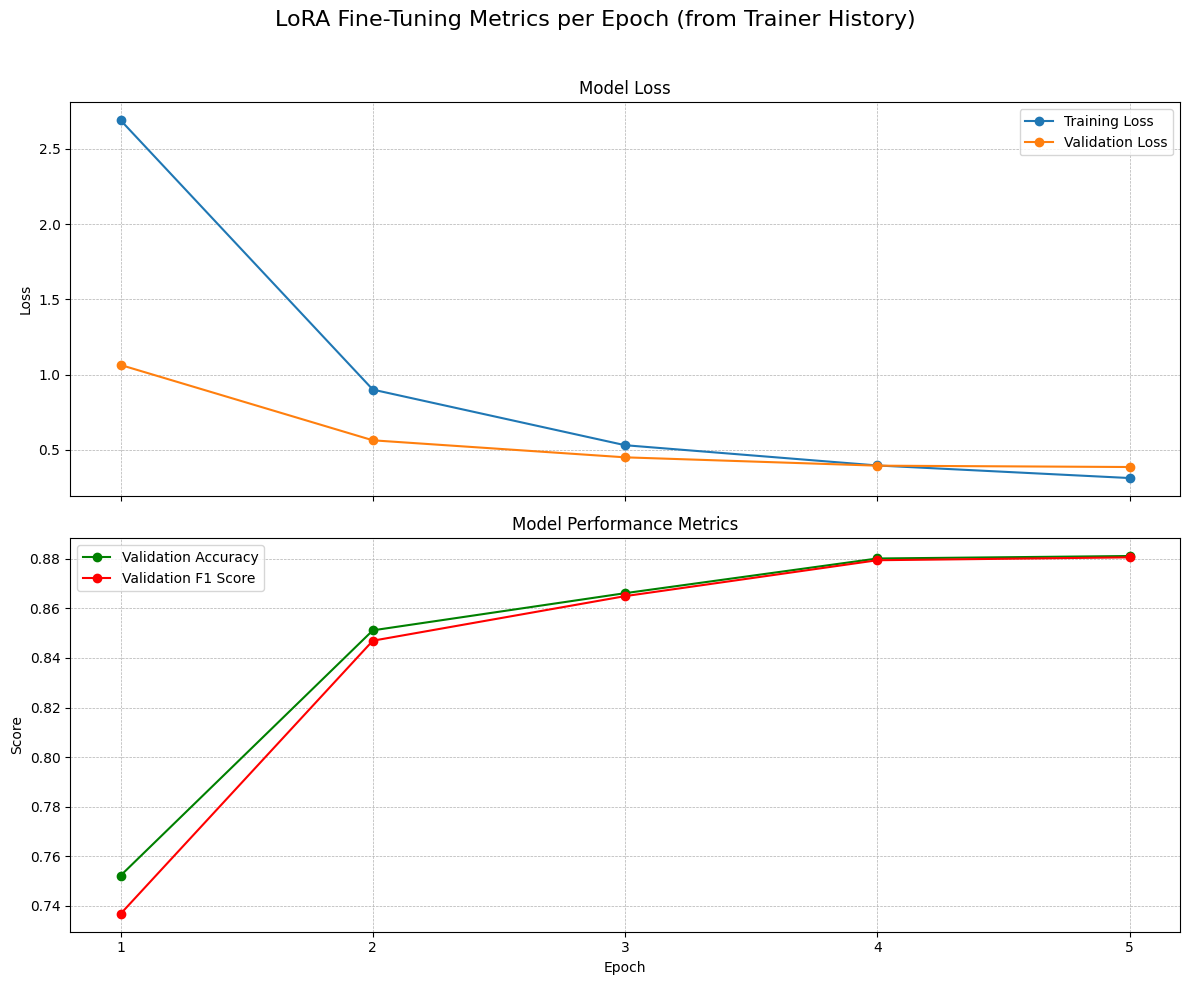

In [ ]:
import matplotlib.pyplot as plt

# Step 1: Extract metrics using the new, robust function
# Make sure your trainer object is named 'trainer'.
metrics_df = extract_metrics_from_trainer_robust(trainer)

print("Extracted Metrics DataFrame:")
print(metrics_df)

# Step 2: Use the extracted DataFrame to generate the plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
fig.suptitle('LoRA Fine-Tuning Metrics per Epoch (from Trainer History)', fontsize=16)

# Plot 1: Training and Validation Loss
ax1.plot(metrics_df['Epoch'], metrics_df['Training Loss'], 'o-', label='Training Loss')
ax1.plot(metrics_df['Epoch'], metrics_df['Validation Loss'], 'o-', label='Validation Loss')
ax1.set_ylabel('Loss')
ax1.set_title('Model Loss')
ax1.legend()
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot 2: Accuracy and F1 Score
ax2.plot(metrics_df['Epoch'], metrics_df['Accuracy'], 'o-', label='Validation Accuracy', color='g')
ax2.plot(metrics_df['Epoch'], metrics_df['F1 Score'], 'o-', label='Validation F1 Score', color='r')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Score')
ax2.set_title('Model Performance Metrics')
ax2.legend()
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)

# Display the plot
plt.xticks(metrics_df['Epoch'])
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
